# Importação das Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from datetime import datetime

# Importação dos Dados

In [ ]:
data = pd.read_excel("df_unico.xlsx", index_col="data")
data = pd.DataFrame(data["carga"]["2023-06-01 00:00:00":"2023-06-30 23:00:00"])
data.head()

,carga
data,
2023-06-01 00:00:00,10696.0
2023-06-01 01:00:00,9975.0
2023-06-01 02:00:00,9602.0
2023-06-01 03:00:00,9569.0
2023-06-01 04:00:00,9704.0


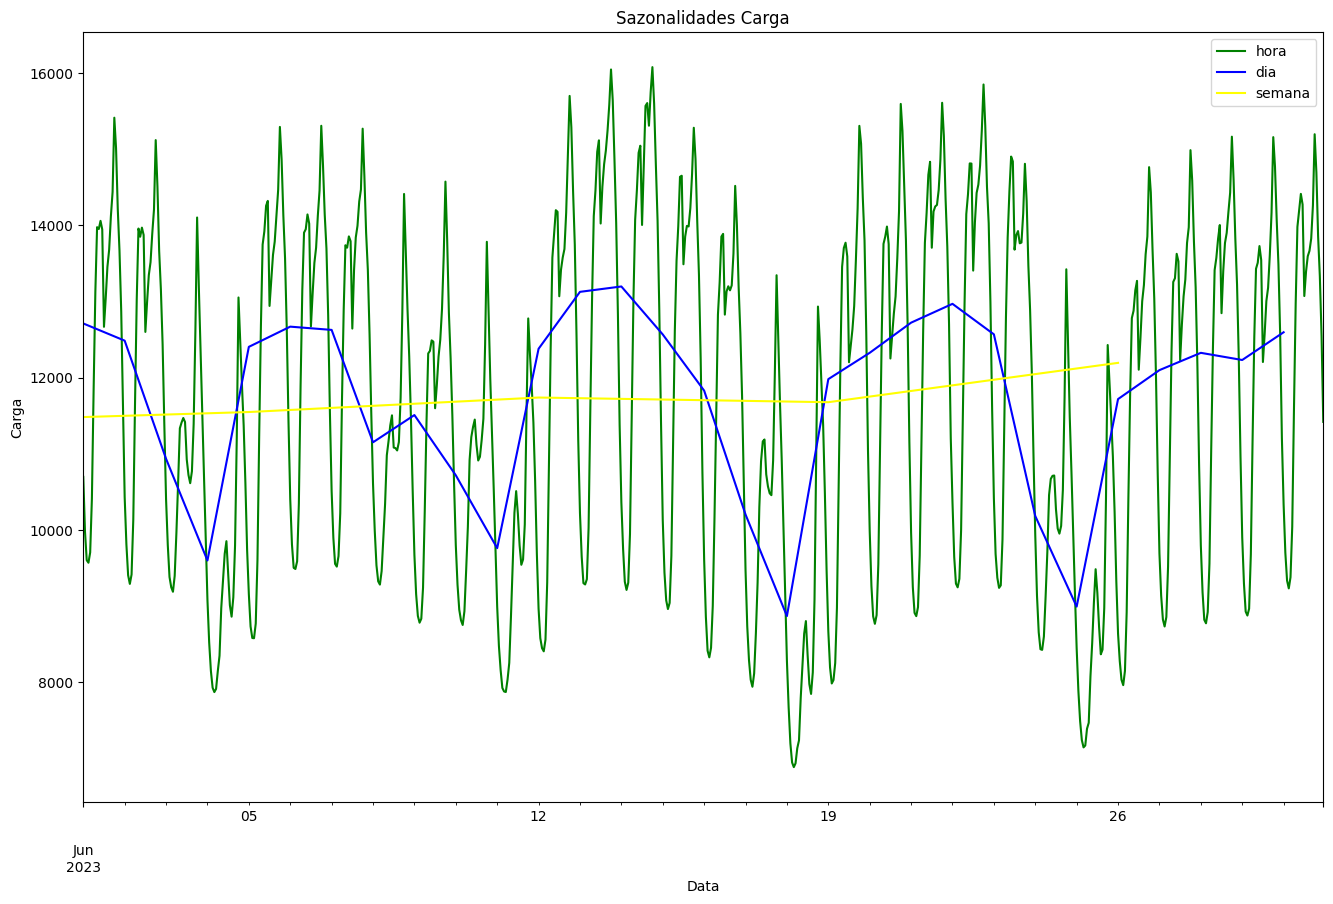

In [ ]:
# Sazonalidade da Carga
fig,ax = plt.subplots()
fig.set_size_inches(16, 10)
data['carga'].plot(ax=ax, label='hora', color='green')
data['carga'].resample('D').mean().plot(ax=ax, label='dia', color='blue')
data['carga'].resample('W').mean().plot(ax=ax, label='semana', color='yellow')

plt.xlim("2023-06-01 00:00:00", "2023-06-30 23:00:00")
plt.xlabel('Data')
plt.ylabel('Carga')
plt.title('Sazonalidades Carga')
plt.legend()

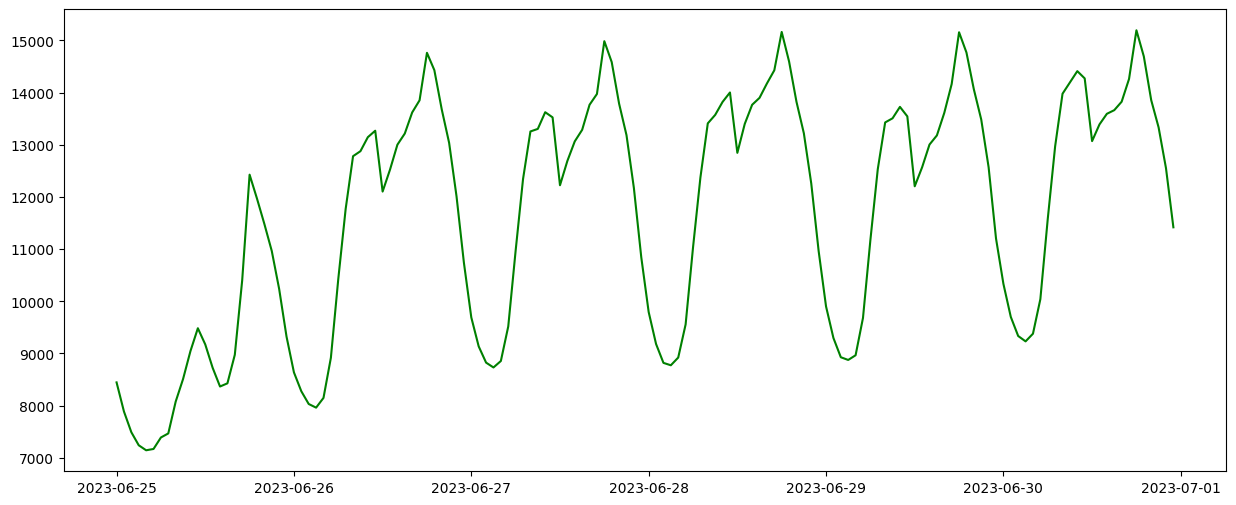

In [ ]:
# Gráfico da série na última semana
plt.plot(data["2023-06-25 00:00:00":], color="green")

# Auto ARIMA

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.2 MB/s eta 0:00:00


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
stepwise_model = auto_arima(data, start_p=1, start_q=1, max_p=1, max_q=1, m=24, start_P=0, seasonal=True, d=1, D=1,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=inf, Time=22.08 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=10017.833, Time=0.45 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=9782.460, Time=6.43 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=5.61 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=9797.855, Time=0.24 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=9724.331, Time=6.64 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=31.58 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=7.96 sec
 ARIMA(0,1,0)(2,1,0)[24]             : AIC=9939.474, Time=3.11 sec
 ARIMA(1,1,1)(2,1,0)[24]             : AIC=9707.594, Time=8.63 sec
 ARIMA(1,1,1)(1,1,0)[24]             : AIC=9763.292, Time=3.93 sec
 ARIMA(1,1,1)(2,1,1)[24]             : AIC=inf, Time=65.81 sec
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=15.97 sec
 ARIMA(0,1,1)(2,1,0)[24]             : AIC=9718.241, Time=8.53 sec
 ARIMA(1,1,1)(2,1,0)[24] intercept   : AIC=9

In [ ]:
print(stepwise_model.aic())

9707.59432554237


In [ ]:
def train_test(st, num_prev):
  proporcao_teste = num_prev/len(st)
  indice_divisao = int((1 - proporcao_teste) * len(st))

  train = st[:indice_divisao]
  test = st[indice_divisao:]

  return train, test

train, test = train_test(data, 23)

In [ ]:
stepwise_model.fit(train)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 24),
      suppress_warnings=True, with_intercept=False)

In [ ]:
future_forecast = stepwise_model.predict(n_periods=23)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["prev_carga"])

In [ ]:
import plotly.express as px
import pandas as pd

# Concatenando os DataFrames
concat_df = pd.concat([test, future_forecast], axis=1)

fig = px.line(concat_df)
fig.update_layout(
    title="Série Histórica + Previsão",
    xaxis=dict(title='Tempo', tickangle=45),
    yaxis=dict(title='carga'),
    showlegend=True,
    legend_title_text='Legenda',
    autosize=False,
    width=800,
    height=500)
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [ ]:
# Concatenando os DataFrames
concat_df2 = pd.concat([data, future_forecast], axis=1)

fig = px.line(concat_df2)
fig.update_layout(
    title="Série Histórica + Previsão",
    xaxis=dict(title='Tempo', tickangle=45),
    yaxis=dict(title='carga'),
    showlegend=True,
    legend_title_text='Legenda',
    autosize=False,
    width=1000,
    height=500)
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Previsão com todo o conjunto de dados, sem dados de teste para validação, que por sinal já foi realizada!

In [ ]:
train = data.loc['2019-01-01 00:00:00':]
stepwise_model.fit(train)
fcast2 = stepwise_model.predict(n_periods = 23)
forecast_index = pd.date_range(data.index.max(), periods=23+1, freq="H")
fcast2 = pd.DataFrame(fcast2, index = forecast_index, columns=["prev_vazao"]).dropna()

In [ ]:
# Concatenando os DataFrames
concat_df3 = pd.concat([data.iloc[-168:], fcast2], axis=1)

fig = px.line(concat_df3)
fig.update_layout(
    title="Série Histórica + Previsão",
    xaxis=dict(title='Tempo', tickangle=45),
    yaxis=dict(title='carga'),
    showlegend=True,
    legend_title_text='Legenda',
    autosize=False,
    width=800,
    height=500)
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

